Reloading Tuner from hyperparam_tuning/nbeats_wearable_data/tuner0.json
10319/10319 [==============================] - 26s 3ms/step
Reloading Tuner from hyperparam_tuning/nbeats_wearable_data/tuner0.json
10319/10319 [==============================] - 23s 2ms/step
Reloading Tuner from hyperparam_tuning/nbeats_wearable_data/tuner0.json
10319/10319 [==============================] - 23s 2ms/step
Reloading Tuner from hyperparam_tuning/nbeats_wearable_data/tuner0.json
10319/10319 [==============================] - 26s 2ms/step
Reloading Tuner from hyperparam_tuning/nbeats_wearable_data/tuner0.json
10319/10319 [==============================] - 26s 3ms/step

Overall Test Accuracy: 0.795718002319336
Fold 1 Test Accuracy: 0.7967
Fold 2 Test Accuracy: 0.7952
Fold 3 Test Accuracy: 0.7953
Fold 4 Test Accuracy: 0.7956
Fold 5 Test Accuracy: 0.7958
Overall Test Accuracy: 0.7957
Average Precision Score: 0.7976
Average Recall Score: 0.7957
Average F1 Score: 0.7958

Overall Classification Report:
Avera

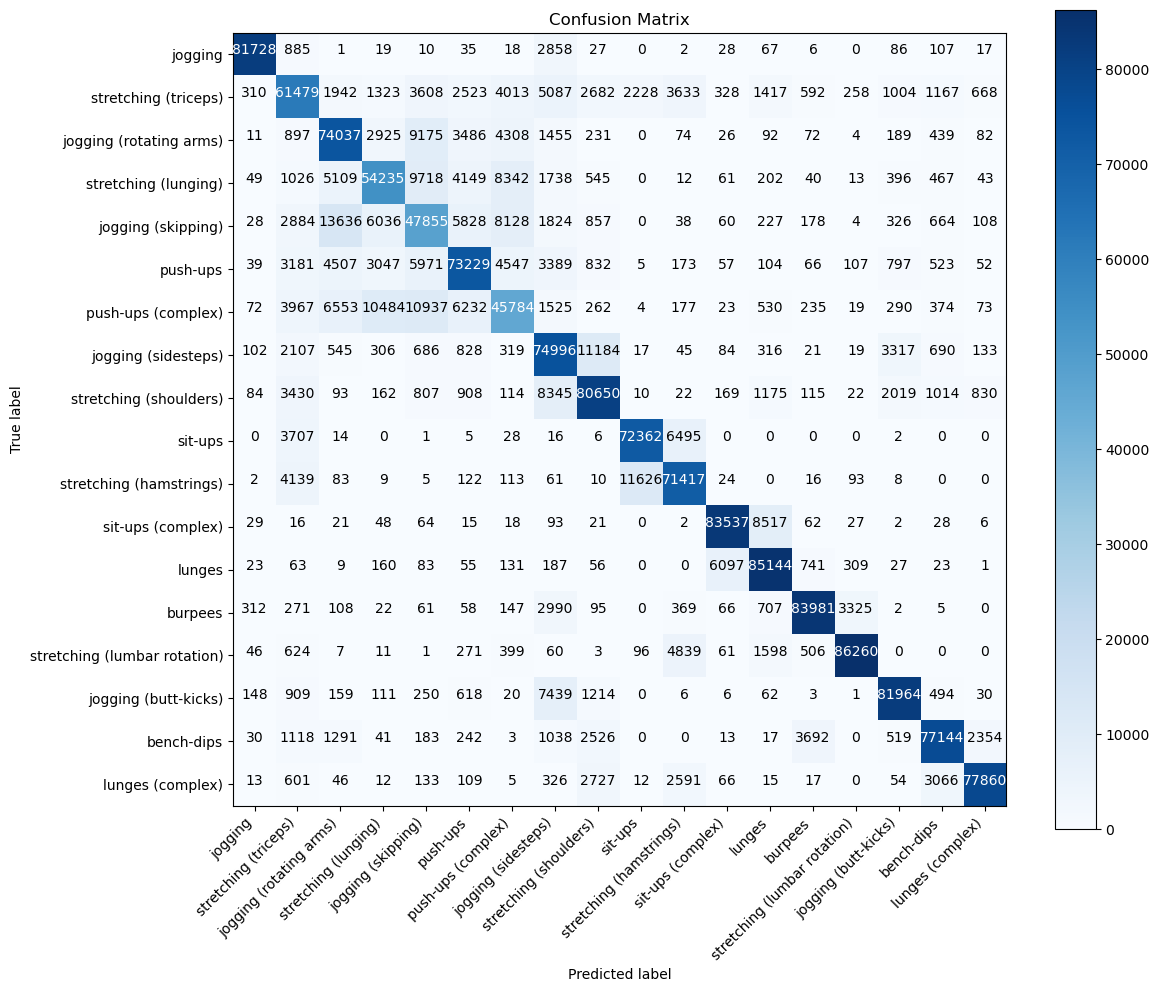

In [4]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import random  # For random operations
import matplotlib.pyplot as plt  # For plotting

# Import necessary components from scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder  # For scaling features and encoding labels
from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation
from sklearn.utils.class_weight import compute_class_weight  # For computing class weights to handle imbalances
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix  # For performance evaluation

# Import necessary components from Keras
from keras.utils import to_categorical  # For converting labels to one-hot encoding
from keras.models import Model  # For defining the model
from keras.layers import Input, Dense, Dropout  # For defining model layers
from keras.callbacks import EarlyStopping  # For early stopping during training
from keras.optimizers import Adam  # For optimization
import keras_tuner as kt  # For hyperparameter tuning

# Define the labels for the activities
labels = ['jogging', 'stretching (triceps)', 'jogging (rotating arms)',
          'stretching (lunging)', 'jogging (skipping)', 'push-ups',
          'push-ups (complex)', 'jogging (sidesteps)',
          'stretching (shoulders)', 'sit-ups', 'stretching (hamstrings)',
          'sit-ups (complex)', 'lunges', 'burpees',
          'stretching (lumbar rotation)', 'jogging (butt-kicks)',
          'bench-dips', 'lunges (complex)']

# Function to load and preprocess a single CSV file
def load_and_preprocess_single_csv(csv_file, scaler=None, label_encoder=None, fit_scaler=False, fit_label_encoder=False):
    data = pd.read_csv(csv_file)  # Load the data from the CSV file
    
    # Clean the data: drop rows with NaN values in 'label' and interpolate remaining NaNs
    data = data.dropna(subset=['label'])
    data = data.interpolate(method='linear', limit_direction='forward', axis=0).dropna()
    
    X = data.drop(['sbj_id', 'label'], axis=1).values  # Extract features
    y = data['label'].values  # Extract labels
    
    if fit_scaler:  # Fit and transform the scaler if required
        X = scaler.fit_transform(X)
    else:  # Otherwise, just transform the features
        X = scaler.transform(X)
    
    if fit_label_encoder:  # Fit and transform the label encoder if required
        y = to_categorical(label_encoder.fit_transform(y))
    else:  # Otherwise, just transform the labels
        y = to_categorical(label_encoder.transform(y))
    
    return X, y

# Function to build the N-BEATS model
def build_nbeats_model(hp, input_dim, forecast_length):
    input_layer = Input(shape=(input_dim,))  # Define the input layer with the shape of input_dim
    units = hp.Int('units', min_value=64, max_value=256, step=64)  # Hyperparameter for the number of units in Dense layers
    num_blocks = hp.Int('num_blocks', min_value=2, max_value=4, step=1)  # Hyperparameter for the number of blocks
    num_layers = hp.Int('num_layers', min_value=2, max_value=4, step=1)  # Hyperparameter for the number of layers within each block
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)  # Hyperparameter for dropout rate

    x = input_layer
    for _ in range(num_blocks):  # Iterate over the number of blocks
        for _ in range(num_layers):  # Iterate over the number of layers in each block
            x = Dense(units, activation='relu')(x)  # Add Dense layer with ReLU activation
            x = Dropout(dropout_rate)(x)  # Add Dropout layer
    
    # Forecasting layer with softmax activation
    forecast = Dense(forecast_length, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=forecast)  # Define the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')  # Hyperparameter for learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model
    
    return model

# Function to train and evaluate the model
def train_and_evaluate(csv_files, n_splits=5, max_trials=10, executions_per_trial=1):
    random.shuffle(csv_files)  # Shuffle the CSV files
    all_X = []
    all_y = []

    # Initialize the scaler and label encoder
    scaler = StandardScaler()
    label_encoder = LabelEncoder()
    for csv_file in csv_files:
        X, y = load_and_preprocess_single_csv(csv_file, scaler, label_encoder, fit_scaler=True, fit_label_encoder=True)  # Load and preprocess data
        all_X.append(X)
        all_y.append(y)
    
    all_X = np.concatenate(all_X, axis=0)  # Concatenate all features
    all_y = np.concatenate(all_y, axis=0)  # Concatenate all labels

    # Cross-validation setup
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    test_accuracies = []
    all_predictions = []
    all_true_labels = []
    for train_index, test_index in kf.split(all_X, np.argmax(all_y, axis=1)):
        X_train, X_test = all_X[train_index], all_X[test_index]
        y_train, y_test = all_y[train_index], all_y[test_index]

        class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))  # Compute class weights
        class_weights = {i: weight for i, weight in enumerate(class_weights)}  # Create a dictionary of class weights

        # Define the tuner for hyperparameter tuning
        tuner = kt.RandomSearch(
            hypermodel=lambda hp: build_nbeats_model(hp, input_dim=X_train.shape[1], forecast_length=y_train.shape[1]),
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory='hyperparam_tuning',
            project_name='nbeats_wearable_data'
        )

        # Early stopping callback
        stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Perform hyperparameter search
        tuner.search(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[stop_early], class_weight=class_weights)

        best_model = tuner.get_best_models(num_models=1)[0]  # Get the best model

        _, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)  # Evaluate the best model on the test set
        test_accuracies.append(test_accuracy)

        y_pred = np.argmax(best_model.predict(X_test), axis=1)  # Make predictions
        all_predictions.append(y_pred)
        all_true_labels.append(np.argmax(y_test, axis=1))

    # Compute overall accuracy
    overall_accuracy = np.mean(test_accuracies)

    # Flatten predictions and true labels for classification report
    all_predictions = np.concatenate(all_predictions)
    all_true_labels = np.concatenate(all_true_labels)

    # Compute metrics
    average_f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    average_recall = recall_score(all_true_labels, all_predictions, average='weighted')
    average_precision = precision_score(all_true_labels, all_predictions, average='weighted')

    print("\nOverall Test Accuracy:", overall_accuracy)
    for i, test_accuracy in enumerate(test_accuracies):
        print(f"Fold {i + 1} Test Accuracy: {test_accuracy:.4f}")
    print(f"Overall Test Accuracy: {overall_accuracy:.4f}")
    print(f"Average Precision Score: {average_precision:.4f}")
    print(f"Average Recall Score: {average_recall:.4f}")
    print(f"Average F1 Score: {average_f1:.4f}")

    # Print overall classification report
    print("\nOverall Classification Report:")
    print("Average metrics weighted by support across folds:")
    print(classification_report(all_true_labels, all_predictions, digits=4))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Plot confusion matrix with annotations
    plt.figure(figsize=(12, 10))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2. else "black")

    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Loading the files
if __name__ == "__main__":
    # List of all CSV files
    csv_files = [
        'data/wear/raw/inertial/sbj_0.csv',
        'data/wear/raw/inertial/sbj_1.csv',
        'data/wear/raw/inertial/sbj_2.csv',
        'data/wear/raw/inertial/sbj_3.csv',
        'data/wear/raw/inertial/sbj_4.csv',
        'data/wear/raw/inertial/sbj_5.csv',
        'data/wear/raw/inertial/sbj_6.csv',
        'data/wear/raw/inertial/sbj_7.csv',
        'data/wear/raw/inertial/sbj_8.csv',
        'data/wear/raw/inertial/sbj_9.csv',
        'data/wear/raw/inertial/sbj_10.csv',
        'data/wear/raw/inertial/sbj_11.csv',
        'data/wear/raw/inertial/sbj_12.csv',
        'data/wear/raw/inertial/sbj_13.csv',
        'data/wear/raw/inertial/sbj_14.csv',
        'data/wear/raw/inertial/sbj_15.csv',
        'data/wear/raw/inertial/sbj_16.csv',
        'data/wear/raw/inertial/sbj_17.csv',
    ]

    # Perform training and testing with different hyperparameters
    train_and_evaluate(csv_files, n_splits=5, max_trials=10, executions_per_trial=1)
